#### Importing required libraries

In [ ]:
# For reproducibility with CuBLAS
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

In [ ]:
import re
import random
import textwrap
import kagglehub

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from tqdm import tqdm
from typing import List, Optional, Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, multilabel_confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mydrive = '/content/drive/MyDrive'

In [ ]:
EE782   = '/content/drive/MyDrive/EE782'
os.makedirs(EE782, exist_ok=True)

In [ ]:
def set_seed(seed):

    # Numpy/Python RNGs
    random.seed(seed)
    np.random.seed(seed)

    # CPU/GPU RNGs
    torch.manual_seed(seed)  # RNG for CPU tensors
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # RNG for all GPU tensors

    # cuDNN determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

In [ ]:
SEED = 42   # 123, 999, etc.
set_seed(SEED)
print(f"Seed set to {SEED}")

Seed set to 42


#### CheXpert-v1.0-small(Kaggle)

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("ashery/chexpert")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chexpert' dataset.
Path to dataset files: /kaggle/input/chexpert


#### EDA of CheXpert-v1.0-small dataset

In [ ]:
!ls /kaggle/input/chexpert

train  train.csv  valid  valid.csv


In [ ]:
!ls /kaggle/input/chexpert/train

Streaming output truncated to the last 5000 lines.
patient07909  patient20817  patient33725  patient46633	patient59541
patient07910  patient20818  patient33726  patient46634	patient59542
patient07911  patient20819  patient33727  patient46635	patient59543
patient07912  patient20820  patient33728  patient46636	patient59544
patient07913  patient20821  patient33729  patient46637	patient59545
patient07914  patient20822  patient33730  patient46638	patient59546
patient07915  patient20823  patient33731  patient46639	patient59547
patient07916  patient20824  patient33732  patient46640	patient59548
patient07917  patient20825  patient33733  patient46641	patient59549
patient07918  patient20826  patient33734  patient46642	patient59550
patient07919  patient20827  patient33735  patient46643	patient59551
patient07920  patient20828  patient33736  patient46644	patient59552
patient07921  patient20829  patient33737  patient46645	patient59553
patient07922  patient20830  patient33738  patient46646	patient595

In [ ]:
!ls /kaggle/input/chexpert/train/patient00001

study1


In [ ]:
!ls /kaggle/input/chexpert/train/patient00001/study1

view1_frontal.jpg


In [ ]:
img_pth = '/kaggle/input/chexpert/train/patient00001/study1/view1_frontal.jpg'
img = cv2.imread(img_pth)
print(img.shape)

(320, 389, 3)


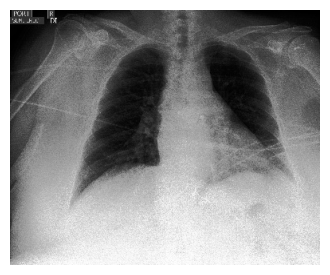

In [ ]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4,4))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

#### Chexpert Data

In [ ]:
DATA_DIR  = '/kaggle/input/chexpert'
TRAIN_DIR = os.path.join(DATA_DIR,'train')
VALID_DIR = os.path.join(DATA_DIR,'valid')
TRAIN_CSV = os.path.join(DATA_DIR,'train.csv')
VALID_CSV = os.path.join(DATA_DIR,'valid.csv')

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
print(train_df.shape)
train_df.head()

(223414, 19)


Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
3         Lateral   NaN         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           NaN          NaN    NaN            NaN        NaN          NaN   
1           1.0          NaN   -1.0           -1.0        NaN         -1.0   
2           1.0          NaN    NaN           -1.0        NaN          NaN   
3           1.0          NaN    NaN           -1.0        NaN          NaN   
4           NaN          NaN    1.0            NaN        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               NaN            NaN       NaN              1.0  
1           NaN              -1.0            NaN       1.0              NaN  
2           NaN               NaN            NaN       1.0              NaN  
3           NaN               NaN            NaN       1.0              NaN  
4           0.0               NaN            NaN       NaN              NaN

In [ ]:
val_df = pd.read_csv(VALID_CSV)
print(val_df.shape)
val_df.head()

(234, 19)


Path     Sex  Age  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...    Male   73   
1  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
2  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
3  CheXpert-v1.0-small/valid/patient64543/study1/...    Male   85   
4  CheXpert-v1.0-small/valid/patient64544/study1/...  Female   42   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         0.0                         1.0           1.0   
1         Frontal    PA         0.0                         0.0           0.0   
2         Lateral   NaN         0.0                         0.0           0.0   
3         Frontal    AP         0.0                         1.0           0.0   
4         Frontal    AP         1.0                         0.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           1.0          0.0    0.0            0.0        0.0          0.0   
1           0.0          0.0    0.0            0.0        0.0          0.0   
2           0.0          0.0    0.0            0.0        0.0          0.0   
3           1.0          0.0    1.0            0.0        0.0          0.0   
4           0.0          0.0    0.0            0.0        0.0          0.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               0.0            0.0       0.0              0.0  
1           0.0               0.0            0.0       0.0              1.0  
2           0.0               0.0            0.0       0.0              1.0  
3           0.0               0.0            0.0       0.0              0.0  
4           0.0               0.0            0.0       0.0              0.0

#### Selecting Only Frontal Images (ignoring lateral images)

In [ ]:
train_df = train_df[train_df['Frontal/Lateral'] == 'Frontal']
print("After filtering frontal images:", len(train_df))

After filtering frontal images: 191027


In [ ]:
train_df.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   
5  CheXpert-v1.0-small/train/patient00004/study1/...  Female   20   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   
5         Frontal    PA         1.0                         0.0           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           NaN          NaN    NaN            NaN        NaN          NaN   
1           1.0          NaN   -1.0           -1.0        NaN         -1.0   
2           1.0          NaN    NaN           -1.0        NaN          NaN   
4           NaN          NaN    1.0            NaN        NaN          NaN   
5           NaN          NaN    NaN            0.0        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               NaN            NaN       NaN              1.0  
1           NaN              -1.0            NaN       1.0              NaN  
2           NaN               NaN            NaN       1.0              NaN  
4           0.0               NaN            NaN       NaN              NaN  
5           NaN               0.0            NaN       NaN              NaN

In [ ]:
val_df = val_df[val_df['Frontal/Lateral'] == 'Frontal']
print("After filtering frontal images:", len(val_df))

After filtering frontal images: 202


In [ ]:
val_df.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...    Male   73   
1  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
3  CheXpert-v1.0-small/valid/patient64543/study1/...    Male   85   
4  CheXpert-v1.0-small/valid/patient64544/study1/...  Female   42   
5  CheXpert-v1.0-small/valid/patient64545/study1/...  Female   55   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         0.0                         1.0           1.0   
1         Frontal    PA         0.0                         0.0           0.0   
3         Frontal    AP         0.0                         1.0           0.0   
4         Frontal    AP         1.0                         0.0           0.0   
5         Frontal    AP         0.0                         1.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           1.0          0.0    0.0            0.0        0.0          0.0   
1           0.0          0.0    0.0            0.0        0.0          0.0   
3           1.0          0.0    1.0            0.0        0.0          0.0   
4           0.0          0.0    0.0            0.0        0.0          0.0   
5           1.0          0.0    0.0            0.0        0.0          1.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               0.0            0.0       0.0              0.0  
1           0.0               0.0            0.0       0.0              1.0  
3           0.0               0.0            0.0       0.0              0.0  
4           0.0               0.0            0.0       0.0              0.0  
5           0.0               1.0            0.0       0.0              0.0

#### Labels

In [ ]:
# canonical labels
canonical = [
    "No Finding",
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Pleural Effusion",
    "Pneumonia",
    "Pneumothorax"]

In [ ]:
# mapping for CheXpert CSV columns -> CANONICAL
chexpert_to_canon = {
    "No Finding": "No Finding",
    "Atelectasis": "Atelectasis",
    "Cardiomegaly": "Cardiomegaly",
    "Lung Opacity": "Consolidation",    # unifying CheXpert "Lung Opacity" -> "Consolidation"
    "Edema": "Edema",
    "Pleural Effusion": "Pleural Effusion",
    "Pneumonia": "Pneumonia",
    "Pneumothorax": "Pneumothorax",
    "Consolidation": "Consolidation",
}

In [ ]:
# mapping for NIH ChestX-ray14 -> CANONICAL
nih_to_canon = {
    "No Finding": "No Finding",
    "Atelectasis": "Atelectasis",
    "Cardiomegaly": "Cardiomegaly",
    "Consolidation": "Consolidation",
    "Edema": "Edema",
    "Effusion": "Pleural Effusion",   # mapping NIH "Effusion" -> "Pleural Effusion"
    "Pneumonia": "Pneumonia",
    "Pneumothorax": "Pneumothorax",
    # NIH has many other columns (Mass, Nodule, Infiltration, etc.)
    # these are ignored or mapped to None (not used)
}

In [ ]:
def make_canonical_df(df_raw: pd.DataFrame, mapping: dict, canonical: list, path_col="Path"):
    out = pd.DataFrame()
    out["Path"] = df_raw[path_col].values

    for c in canonical:
        out[c] = 0.0
        out[c + "_mask"] = 0

    # group source columns that map to the same canonical target
    from collections import defaultdict
    grouped = defaultdict(list)
    for src_col, canon_col in mapping.items():
        grouped[canon_col].append(src_col)

    for canon_col, src_cols in grouped.items():
        for src_col in src_cols:
            if src_col not in df_raw.columns:
                continue
            vals = df_raw[src_col].values
            for i, v in enumerate(vals):
                if pd.isna(v) or float(v) == -1.0:
                    continue
                vv = float(v)
                # logical OR — if any mapped column has a positive finding, mark as positive
                if vv == 1.0:
                    out.at[i, canon_col] = 1.0
                # mark mask as valid if *any* mapped column has a valid value
                out.at[i, canon_col + "_mask"] = 1

    return out

#### Canonical DataFrames

In [ ]:
train_df_canon = make_canonical_df(train_df, chexpert_to_canon,canonical,"Path")

In [ ]:
train_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/train/patient00001/study1/...         1.0   
1  CheXpert-v1.0-small/train/patient00002/study2/...         0.0   
2  CheXpert-v1.0-small/train/patient00002/study1/...         0.0   
3  CheXpert-v1.0-small/train/patient00003/study1/...         0.0   
4  CheXpert-v1.0-small/train/patient00004/study1/...         1.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 0           0.0   
1                0          0.0                 0           0.0   
2                0          0.0                 0           0.0   
3                0          0.0                 0           0.0   
4                1          0.0                 0           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  0            0.0                   0    0.0           0   
1                  0            1.0                   1    0.0           0   
2                  0            1.0                   1    0.0           0   
3                  0            0.0                   0    1.0           1   
4                  0            0.0                   1    0.0           0   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      0        0.0               0   
1               0.0                      0        0.0               0   
2               0.0                      0        0.0               0   
3               0.0                      0        0.0               0   
4               0.0                      1        0.0               0   

   Pneumothorax  Pneumothorax_mask  
0           0.0                  1  
1           0.0                  0  
2           0.0                  0  
3           0.0                  1  
4           0.0                  0

In [ ]:
val_df_canon = make_canonical_df(val_df, chexpert_to_canon,canonical,"Path")

In [ ]:
val_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...         0.0   
1  CheXpert-v1.0-small/valid/patient64542/study1/...         0.0   
2  CheXpert-v1.0-small/valid/patient64543/study1/...         0.0   
3  CheXpert-v1.0-small/valid/patient64544/study1/...         1.0   
4  CheXpert-v1.0-small/valid/patient64545/study1/...         0.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 1           1.0   
1                1          0.0                 1           0.0   
2                1          0.0                 1           0.0   
3                1          0.0                 1           0.0   
4                1          1.0                 1           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  1            1.0                   1    0.0           1   
1                  1            0.0                   1    0.0           1   
2                  1            1.0                   1    1.0           1   
3                  1            0.0                   1    0.0           1   
4                  1            1.0                   1    0.0           1   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      1        0.0               1   
1               0.0                      1        0.0               1   
2               0.0                      1        0.0               1   
3               0.0                      1        0.0               1   
4               1.0                      1        0.0               1   

   Pneumothorax  Pneumothorax_mask  
0           0.0                  1  
1           0.0                  1  
2           0.0                  1  
3           0.0                  1  
4           0.0                  1

#### Patient wise splitting the data to prevent data leakage

In [ ]:
def extract_patient_id(path: str) -> str:
    """Extract patient identifier like 'patient00001' from a file path."""
    match = re.search(r"(patient\d+)", path)
    return match.group(1) if match else None

In [ ]:
train_df_canon["PatientID"] = train_df_canon["Path"].apply(extract_patient_id)

In [ ]:
train_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/train/patient00001/study1/...         1.0   
1  CheXpert-v1.0-small/train/patient00002/study2/...         0.0   
2  CheXpert-v1.0-small/train/patient00002/study1/...         0.0   
3  CheXpert-v1.0-small/train/patient00003/study1/...         0.0   
4  CheXpert-v1.0-small/train/patient00004/study1/...         1.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 0           0.0   
1                0          0.0                 0           0.0   
2                0          0.0                 0           0.0   
3                0          0.0                 0           0.0   
4                1          0.0                 0           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  0            0.0                   0    0.0           0   
1                  0            1.0                   1    0.0           0   
2                  0            1.0                   1    0.0           0   
3                  0            0.0                   0    1.0           1   
4                  0            0.0                   1    0.0           0   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      0        0.0               0   
1               0.0                      0        0.0               0   
2               0.0                      0        0.0               0   
3               0.0                      0        0.0               0   
4               0.0                      1        0.0               0   

   Pneumothorax  Pneumothorax_mask     PatientID  
0           0.0                  1  patient00001  
1           0.0                  0  patient00002  
2           0.0                  0  patient00002  
3           0.0                  1  patient00003  
4           0.0                  0  patient00004

* The "train" split of the dataset is split into (train + val) data
* The "valid" split of the dataset is considered as test data for evaluation

In [ ]:
# unique patient IDs
unique_patients = train_df_canon["PatientID"].unique()

train_patients, val_patients = train_test_split(
    unique_patients,
    test_size=0.15,      # 15% for validation
    random_state=SEED,
    shuffle=True
)

# assign split labels
train_df_canon["split"] = train_df_canon["PatientID"].apply(
    lambda x: "val" if x in val_patients else "train")

print(train_df_canon["split"].value_counts())

split
train    161996
val       29031
Name: count, dtype: int64


In [ ]:
train_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/train/patient00001/study1/...         1.0   
1  CheXpert-v1.0-small/train/patient00002/study2/...         0.0   
2  CheXpert-v1.0-small/train/patient00002/study1/...         0.0   
3  CheXpert-v1.0-small/train/patient00003/study1/...         0.0   
4  CheXpert-v1.0-small/train/patient00004/study1/...         1.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 0           0.0   
1                0          0.0                 0           0.0   
2                0          0.0                 0           0.0   
3                0          0.0                 0           0.0   
4                1          0.0                 0           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  0            0.0                   0    0.0           0   
1                  0            1.0                   1    0.0           0   
2                  0            1.0                   1    0.0           0   
3                  0            0.0                   0    1.0           1   
4                  0            0.0                   1    0.0           0   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      0        0.0               0   
1               0.0                      0        0.0               0   
2               0.0                      0        0.0               0   
3               0.0                      0        0.0               0   
4               0.0                      1        0.0               0   

   Pneumothorax  Pneumothorax_mask     PatientID  split  
0           0.0                  1  patient00001  train  
1           0.0                  0  patient00002  train  
2           0.0                  0  patient00002  train  
3           0.0                  1  patient00003  train  
4           0.0                  0  patient00004  train

In [ ]:
train_data = train_df_canon[train_df_canon["split"] == "train"].reset_index(drop=True)
val_data   = train_df_canon[train_df_canon["split"] == "val"].reset_index(drop=True)
test_data  = val_df_canon

print(f"""Length of each split:
      Train: {len(train_data)}
      Val  : {len(val_data)}
      Test : {len(test_data)}""")

Length of each split:
      Train: 161996
      Val  : 29031
      Test : 202


In [ ]:
train_data_small = train_data.sample(frac=0.1, random_state=SEED).reset_index(drop=True)
val_data_small   = val_data.sample(frac=0.1, random_state=SEED).reset_index(drop=True)

#### Data Transforms

In [ ]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),     # RandomHorizontalFlip() uses torch.rand under the hood, global seed ensures reproducibilty
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # gray→RGB
    transforms.Normalize(mean= imagenet_mean,   # IMAGENET statistics
                         std = imagenet_std)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
   transforms.Normalize(mean= imagenet_mean,   # IMAGENET statistics
                        std = imagenet_std)
])

#### Custom Dataset Class

In [ ]:
class CheXpertDataset(Dataset):
    def __init__(self, df, transform=None, target_cols=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.target_cols = target_cols
        self.mask_cols = [c + "_mask" for c in target_cols]
        self.classes = target_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["Path"]
        correct_img_path = img_path.replace("CheXpert-v1.0-small",DATA_DIR)
        image = Image.open(correct_img_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row[self.target_cols].to_numpy(dtype=np.float32))
        mask = torch.tensor(row[self.mask_cols].to_numpy(dtype=np.float32))
        return image, label, mask

#### DataLoaders

In [ ]:
# Seed function for DataLoader workers
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
target_cols = canonical
train_dataset = CheXpertDataset(train_data_small,   train_transforms, target_cols)
val_dataset   = CheXpertDataset(val_data_small ,    val_transforms ,  target_cols)
chexpert_test_dataset  = CheXpertDataset(test_data, val_transforms ,  target_cols)

In [ ]:
# Generator for DataLoader
g = torch.Generator()
g.manual_seed(SEED)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

chexpert_test_loader = DataLoader(
    chexpert_test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

In [ ]:
img, label, mask = train_dataset[0]
print(type(img), img.shape)
print(type(label), label)

<class 'torch.Tensor'> torch.Size([3, 224, 224])
<class 'torch.Tensor'> tensor([0., 0., 0., 0., 0., 0., 0., 1.])


In [ ]:
images, labels, mask = next(iter(train_loader))
print(images.shape)   # [BATCH_SIZE, 3, 224, 224]
print(labels.shape)   # [BATCH_SIZE,num_classes]
print(mask.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 8])
torch.Size([32, 8])


#### Classfication Models

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

def build_resnet50(num_classes, pretrained=True):
  model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
  in_features = model.fc.in_features
  model.fc = nn.Linear(in_features, num_classes)
  return model

def build_densenet121(num_classes, pretrained=True):
  model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)
  in_features = model.classifier.in_features
  model.classifier = nn.Sequential(
      nn.Dropout(0.3),
      nn.Linear(in_features, num_classes))
  return model

def build_vit_b_16(num_classes, pretrained=True):
  model = models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None)
  in_features = model.heads.head.in_features
  model.heads.head = nn.Linear(in_features, num_classes)
  return model

def build_convnext(num_classes, pretrained=True):
  model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
  model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
  return model

### Training

##### Helper Functions

In [ ]:
num_classes = len(canonical)
num_classes

8

In [ ]:
def masked_bce_loss(outputs, targets, masks, criterion):
    """
    Compute BCE loss while ignoring masked labels.

    outputs: (B, C) raw logits
    targets: (B, C) 0/1
    masks:   (B, C) 1=valid, 0=ignore
    """
    loss = criterion(outputs, targets)  # per-element
    loss = loss * masks                 # zero-out ignored labels
    valid = masks.sum()
    if valid == 0:
        return torch.tensor(0.0, device=outputs.device)
    return loss.sum() / valid

In [ ]:
def train(CHECKPOINT_DIR, model, train_loader, val_loader, criterion, optimizer, scheduler,
          num_epochs, resume_epoch=None, patience=5):
    start_epoch = 1
    best_val_acc = 0.0
    epochs_no_improve = 0

    metrics = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    # Resume training if requested
    if resume_epoch is not None:
        resume_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{resume_epoch-1}.pth")
        if os.path.exists(resume_path):
            checkpoint = torch.load(resume_path, map_location=device)
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            best_val_acc = checkpoint.get("best_val_acc", 0.0)
            start_epoch = resume_epoch
            print(f"Resuming from epoch {start_epoch} with best val acc {best_val_acc:.4f}")
        else:
            print(f"Checkpoint not found at {resume_path}, starting fresh.")

    for epoch in range(start_epoch, num_epochs + 1):
        print(f"----------------- Epoch {epoch} -----------------")

        # ---------- TRAIN ----------
        model.train()
        train_loss_total = 0.0
        train_corrects_total = 0.0
        total_train_labels = 0.0

        for images, labels, masks in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = masked_bce_loss(outputs, labels, masks, criterion)
            loss.backward()
            optimizer.step()

            train_loss_total += loss.item() * masks.sum().item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            train_corrects_total += ((preds == labels) * masks).sum().item()
            total_train_labels += masks.sum().item()

        epoch_train_loss = train_loss_total / total_train_labels
        epoch_train_acc = train_corrects_total / total_train_labels

        metrics["train_loss"].append(epoch_train_loss)
        metrics["train_acc"].append(epoch_train_acc)
        print(f"Train Loss: {epoch_train_loss:.4f} | Train Accuracy: {epoch_train_acc:.4f}\n")

        # ---------- VALIDATION ----------
        model.eval()
        val_loss_total = 0.0
        val_corrects_total = 0.0
        total_val_labels = 0.0

        with torch.no_grad():
            for images, labels, masks in tqdm(val_loader, desc=f"Val Epoch {epoch}"):
                images, labels, masks = images.to(device), labels.to(device), masks.to(device)
                outputs = model(images)
                loss = masked_bce_loss(outputs, labels, masks, criterion)
                val_loss_total += loss.item() * masks.sum().item()

                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                val_corrects_total += ((preds == labels) * masks).sum().item()
                total_val_labels += masks.sum().item()

        epoch_val_loss = val_loss_total / total_val_labels
        epoch_val_acc = val_corrects_total / total_val_labels

        metrics["val_loss"].append(epoch_val_loss)
        metrics["val_acc"].append(epoch_val_acc)
        print(f"Validation Loss: {epoch_val_loss:.4f} | Validation Accuracy: {epoch_val_acc:.4f}\n")

        # ---------- CHECKPOINTING ----------
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch
            epochs_no_improve = 0

            best_ckpt_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
            torch.save({
                "best_epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": epoch_val_loss,
                "best_val_acc": best_val_acc,
                "metrics": metrics,
            }, best_ckpt_path)
            print(f"New best model saved at epoch {best_epoch} with val accuracy = {best_val_acc:.4f}\n")
        else:
            epochs_no_improve += 1

        # Save checkpoint for current epoch
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{epoch}.pth")
        torch.save({
            "epoch": epoch,
            "best_epoch": best_epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": epoch_val_loss,
            "best_val_acc": best_val_acc,
            "metrics": metrics,
        }, checkpoint_path)

        # ---------- EARLY STOPPING ----------
        if epochs_no_improve >= patience and epoch != num_epochs:
            print(f"\nEarly stopping. No improvement in {patience} epochs")
            break

        scheduler.step()

    print(f"\nTraining complete. Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
    return metrics

In [ ]:
def plot_train_val_acc(metrics):
  epochs = range(1, len(metrics['train_acc']) + 1)
  plt.figure(figsize=(5,3))
  plt.plot(epochs, metrics['train_acc'], label='Train Acc')
  plt.plot(epochs, metrics['val_acc'], label='Val Acc')
  plt.legend()
  plt.title('Accuracy vs Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.xticks(epochs)
  plt.show()

In [ ]:
def evaluate_model(model, test_loader, device, classes, threshold=0.5):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for images, labels, masks in test_loader:
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            # Apply mask
            labels = labels * masks
            probs  = probs * masks
            preds  = preds * masks

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()

    print("------ Per-Class Metrics ------ ")
    per_class_auc, per_class_ap = [], []

    for i, cls in enumerate(classes):
        valid_idx = ~np.isnan(all_labels[:, i])
        if valid_idx.sum() == 0:
            continue
        try:
            auc = roc_auc_score(all_labels[valid_idx, i], all_probs[valid_idx, i])
        except ValueError:
            auc = np.nan
        ap = average_precision_score(all_labels[valid_idx, i], all_probs[valid_idx, i])
        per_class_auc.append(auc)
        per_class_ap.append(ap)
        print(f"{cls:20s} | AUC: {auc:.3f} | AP: {ap:.3f}")

    mean_auc = np.nanmean(per_class_auc)
    mean_ap = np.nanmean(per_class_ap)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')

    print("\n------ Summary ------ ")
    print(f"Mean AUC: {mean_auc:.3f}")
    print(f"Mean AP:  {mean_ap:.3f}")
    print(f"Macro F1: {macro_f1:.3f}")
    print(f"Micro F1: {micro_f1:.3f}")

In [ ]:
def visualize_predictions(model, test_loader, device, classes, num_images=12, fontsize=8):
    model.eval()
    plt.figure(figsize=(12, 6))
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std  = [0.229, 0.224, 0.225]

    all_images, all_labels = [], []

    # Collect a subset of images & labels
    with torch.no_grad():
        for images, labels, masks in test_loader:
            all_images.append(images)
            all_labels.append(labels)
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Pick random samples
    random_indices = random.sample(range(len(all_labels)), num_images)

    for i, idx in enumerate(random_indices):
        img = all_images[idx].to(device)
        label = all_labels[idx].to(device)

        outputs = model(img.unsqueeze(0))
        probs = torch.sigmoid(outputs)
        pred = (probs > 0.5).squeeze(0).cpu().numpy()
        true = label.cpu().numpy()

        true_labels = [classes[j] for j, v in enumerate(true) if v == 1]
        pred_labels = [classes[j] for j, v in enumerate(pred) if v == 1]

        # Unnormalize image
        img = img.cpu() * torch.tensor(imagenet_std)[:, None, None] + torch.tensor(imagenet_mean)[:, None, None]
        img = img.permute(1, 2, 0).numpy().clip(0, 1)

        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

        # Create wrapped label strings for clarity
        true_text = "T: " + ", ".join(true_labels) if true_labels else "T: None"
        pred_text = "P: " + ", ".join(pred_labels) if pred_labels else "P: None"
        wrapped_text = "\n".join(textwrap.wrap(true_text + " | " + pred_text, width=40))

        plt.text(0.5, -0.1, wrapped_text, fontsize=fontsize, ha='center', va='top', wrap=True, transform=plt.gca().transAxes)

    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)  # adds spacing between rows
    plt.show()

#### ResNet50

In [ ]:
resnet50_CHECKPOINT_DIR = os.path.join(EE782, f'resnet50_checkpoints_seed_{SEED}')
os.makedirs(resnet50_CHECKPOINT_DIR, exist_ok = True)
resnet50_CHECKPOINT_DIR

'/content/drive/MyDrive/EE782/resnet50_checkpoints_seed_42'

In [ ]:
def test_acc_best_model_resnet50(CHECKPOINT_DIR, num_classes, test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model      = build_resnet50(num_classes, False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()
  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_label_acc = test_corrects.double() / total_test_labels
  return test_label_acc, best_model

In [ ]:
def test_acc_ckpt_resnet50(CHECKPOINT_DIR,num_classes,test_loader,ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_resnet50(num_classes, False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds == labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels

  return test_acc, model

In [ ]:
resnet50_model    = build_resnet50(num_classes)
resnet50_model    = resnet50_model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(resnet50_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train( resnet50_CHECKPOINT_DIR, resnet50_model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 507/507 [02:53<00:00,  2.92it/s]


Train Loss: 0.3366 | Train Acc: 0.8524


Val Epoch 1: 100%|██████████| 91/91 [00:12<00:00,  7.35it/s]


Val Loss: 0.3292 | Val Acc: 0.8562
New best model saved at epoch 1 with val acc = 0.8562
----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 507/507 [02:55<00:00,  2.89it/s]


Train Loss: 0.2976 | Train Acc: 0.8720


Val Epoch 2: 100%|██████████| 91/91 [00:11<00:00,  8.07it/s]


Val Loss: 0.3014 | Val Acc: 0.8742
New best model saved at epoch 2 with val acc = 0.8742
----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 507/507 [02:55<00:00,  2.89it/s]


Train Loss: 0.2675 | Train Acc: 0.8870


Val Epoch 3: 100%|██████████| 91/91 [00:12<00:00,  7.18it/s]


Val Loss: 0.3200 | Val Acc: 0.8679
----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 507/507 [02:55<00:00,  2.90it/s]


Train Loss: 0.2372 | Train Acc: 0.9017


Val Epoch 4: 100%|██████████| 91/91 [00:11<00:00,  7.64it/s]


Val Loss: 0.3167 | Val Acc: 0.8651
----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 507/507 [02:55<00:00,  2.89it/s]


Train Loss: 0.2014 | Train Acc: 0.9203


Val Epoch 5: 100%|██████████| 91/91 [00:12<00:00,  7.34it/s]


Val Loss: 0.3541 | Val Acc: 0.8593
----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 507/507 [02:55<00:00,  2.90it/s]


Train Loss: 0.1537 | Train Acc: 0.9399


Val Epoch 6: 100%|██████████| 91/91 [00:12<00:00,  7.50it/s]


Val Loss: 0.3929 | Val Acc: 0.8625
----------------- Epoch 7 -----------------


Train Epoch 7: 100%|██████████| 507/507 [02:55<00:00,  2.89it/s]


Train Loss: 0.1211 | Train Acc: 0.9554


Val Epoch 7: 100%|██████████| 91/91 [00:11<00:00,  7.84it/s]


Val Loss: 0.4236 | Val Acc: 0.8526

Early stopping triggered after 5 epochs without improvement.

Training complete. Best val acc: 0.8742 at epoch 2


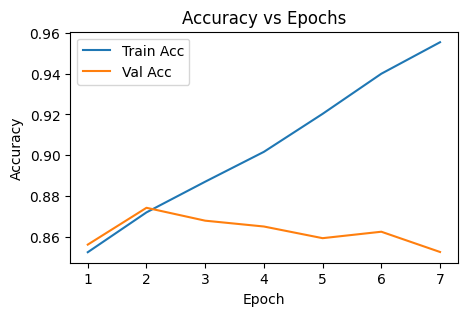

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_resnet50(resnet50_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 2 with val acc = 0.8742
Test Label-wise Accuracy: 51.4851 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.773 | AP: 0.437
Atelectasis          | AUC: 0.831 | AP: 0.709
Cardiomegaly         | AUC: 0.774 | AP: 0.637
Consolidation        | AUC: 0.875 | AP: 0.906
Edema                | AUC: 0.902 | AP: 0.745
Pleural Effusion     | AUC: 0.882 | AP: 0.788
Pneumonia            | AUC: 0.838 | AP: 0.260
Pneumothorax         | AUC: 0.642 | AP: 0.091

------ Summary ------ 
Mean AUC: 0.814
Mean AP:  0.572
Macro F1: 0.440
Micro F1: 0.494


We reproduce a ResNet-50 baseline on CheXpert using masked BCE loss and report AUC = 0.825

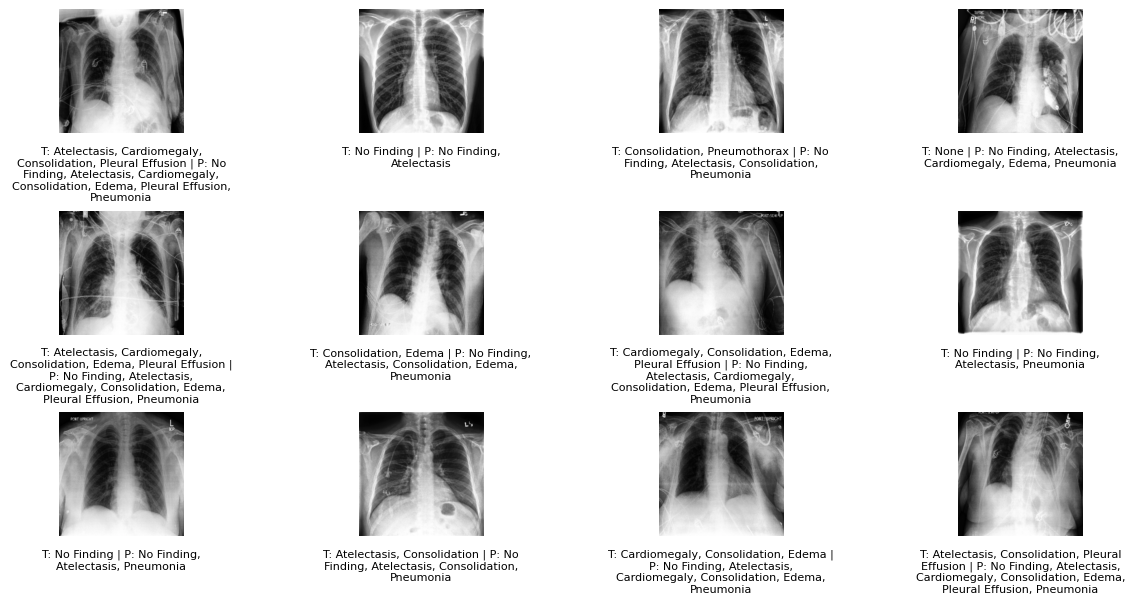

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=12)

---

In [ ]:
t2, ckpt_model= test_acc_ckpt_resnet50(resnet50_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=7)
print(f"Test Label-wise Accuracy: {t2*100:.4f} %")

Loaded model from epoch 7
Test Label-wise Accuracy: 57.5495 %


In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.590 | AP: 0.171
Atelectasis          | AUC: 0.717 | AP: 0.626
Cardiomegaly         | AUC: 0.778 | AP: 0.606
Consolidation        | AUC: 0.851 | AP: 0.873
Edema                | AUC: 0.867 | AP: 0.615
Pleural Effusion     | AUC: 0.863 | AP: 0.712
Pneumonia            | AUC: 0.886 | AP: 0.164
Pneumothorax         | AUC: 0.767 | AP: 0.110

------ Summary ------ 
Mean AUC: 0.790
Mean AP:  0.485
Macro F1: 0.462
Micro F1: 0.517


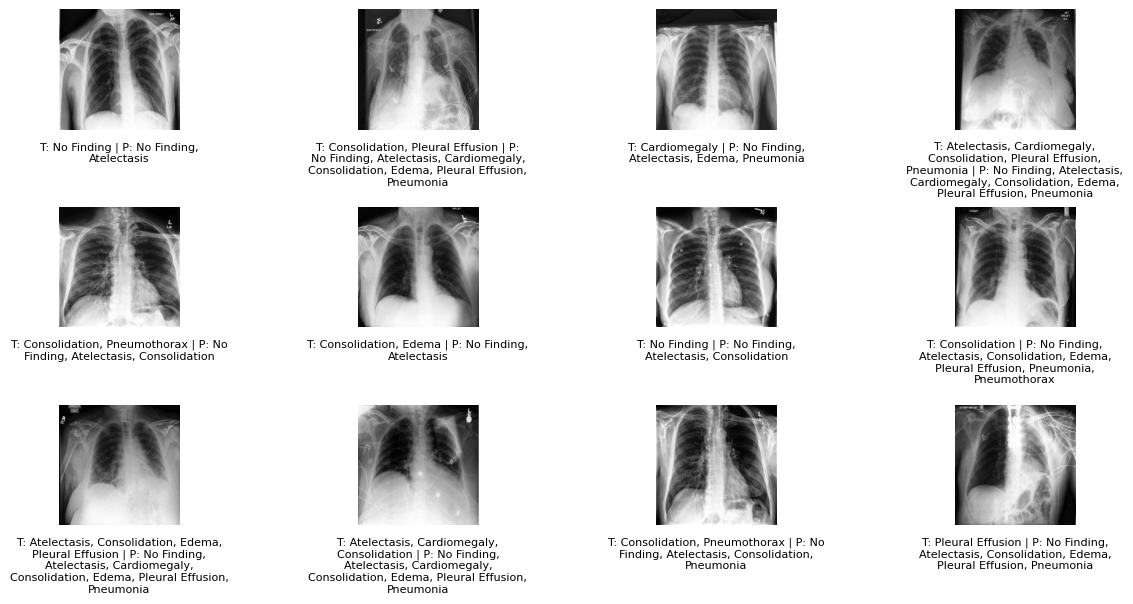

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

#### DenseNet121

In [ ]:
def test_acc_best_model_densenet121(CHECKPOINT_DIR, num_classes, test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model = build_densenet121(num_classes,False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()
  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")

  # Testing
  test_corrects,total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc , best_model

In [ ]:
def test_acc_ckpt_densenet121(CHECKPOINT_DIR, num_classes, test_loader, ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_densenet121(num_classes,False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in chexpert_test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds == labels)*masks).sum()
          total_test_labels  += masks.sum()

  test_acc = test_corrects.double() /  total_test_labels

  return test_acc, model

In [ ]:
densenet121_CHECKPOINT_DIR = os.path.join(EE782, f'densenet121_checkpoints_seed_{SEED}')
os.makedirs(densenet121_CHECKPOINT_DIR, exist_ok=True)

In [ ]:
densenet121_model = build_densenet121(num_classes)
densenet121_model = densenet121_model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(densenet121_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train(densenet121_CHECKPOINT_DIR, densenet121_model, train_loader, val_loader,criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 507/507 [02:59<00:00,  2.82it/s]


Train Loss: 0.3476 | Train Accuracy: 0.8484



Val Epoch 1: 100%|██████████| 91/91 [00:14<00:00,  6.11it/s]


Validation Loss: 0.3014 | Validation Accuracy: 0.8735

New best model saved at epoch 1 with val accuracy = 0.8735

----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 507/507 [03:02<00:00,  2.78it/s]


Train Loss: 0.2956 | Train Accuracy: 0.8744



Val Epoch 2: 100%|██████████| 91/91 [00:13<00:00,  6.91it/s]


Validation Loss: 0.2944 | Validation Accuracy: 0.8742

New best model saved at epoch 2 with val accuracy = 0.8742

----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 507/507 [02:53<00:00,  2.92it/s]


Train Loss: 0.2677 | Train Accuracy: 0.8877



Val Epoch 3: 100%|██████████| 91/91 [00:13<00:00,  6.84it/s]


Validation Loss: 0.2975 | Validation Accuracy: 0.8733

----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 507/507 [03:01<00:00,  2.79it/s]


Train Loss: 0.2370 | Train Accuracy: 0.9023



Val Epoch 4: 100%|██████████| 91/91 [00:15<00:00,  6.01it/s]


Validation Loss: 0.3118 | Validation Accuracy: 0.8763

New best model saved at epoch 4 with val accuracy = 0.8763

----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 507/507 [02:59<00:00,  2.83it/s]


Train Loss: 0.2022 | Train Accuracy: 0.9177



Val Epoch 5: 100%|██████████| 91/91 [00:12<00:00,  7.28it/s]


Validation Loss: 0.3259 | Validation Accuracy: 0.8715

----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 507/507 [02:56<00:00,  2.87it/s]


Train Loss: 0.1617 | Train Accuracy: 0.9371



Val Epoch 6: 100%|██████████| 91/91 [00:11<00:00,  7.72it/s]


Validation Loss: 0.3494 | Validation Accuracy: 0.8741

----------------- Epoch 7 -----------------


Train Epoch 7: 100%|██████████| 507/507 [02:59<00:00,  2.83it/s]


Train Loss: 0.1218 | Train Accuracy: 0.9539



Val Epoch 7: 100%|██████████| 91/91 [00:14<00:00,  6.45it/s]


Validation Loss: 0.3819 | Validation Accuracy: 0.8703

----------------- Epoch 8 -----------------


Train Epoch 8: 100%|██████████| 507/507 [02:52<00:00,  2.94it/s]


Train Loss: 0.0906 | Train Accuracy: 0.9681



Val Epoch 8: 100%|██████████| 91/91 [00:12<00:00,  7.43it/s]


Validation Loss: 0.4005 | Validation Accuracy: 0.8703

----------------- Epoch 9 -----------------


Train Epoch 9: 100%|██████████| 507/507 [02:51<00:00,  2.96it/s]


Train Loss: 0.0658 | Train Accuracy: 0.9779



Val Epoch 9: 100%|██████████| 91/91 [00:12<00:00,  7.22it/s]


Validation Loss: 0.4306 | Validation Accuracy: 0.8669


Early stopping. No improvement in 5 epochs

Training complete. Best validation accuracy: 0.8763 at epoch 4


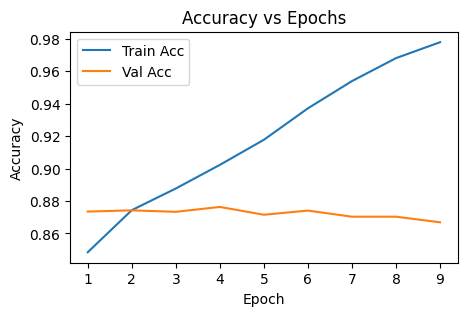

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_densenet121(densenet121_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 4 with val acc = 0.8763
Test Label-wise Accuracy: 53.4653 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.549 | AP: 0.149
Atelectasis          | AUC: 0.843 | AP: 0.686
Cardiomegaly         | AUC: 0.820 | AP: 0.684
Consolidation        | AUC: 0.889 | AP: 0.906
Edema                | AUC: 0.871 | AP: 0.685
Pleural Effusion     | AUC: 0.862 | AP: 0.740
Pneumonia            | AUC: 0.883 | AP: 0.295
Pneumothorax         | AUC: 0.837 | AP: 0.122

------ Summary ------ 
Mean AUC: 0.819
Mean AP:  0.533
Macro F1: 0.458
Micro F1: 0.508


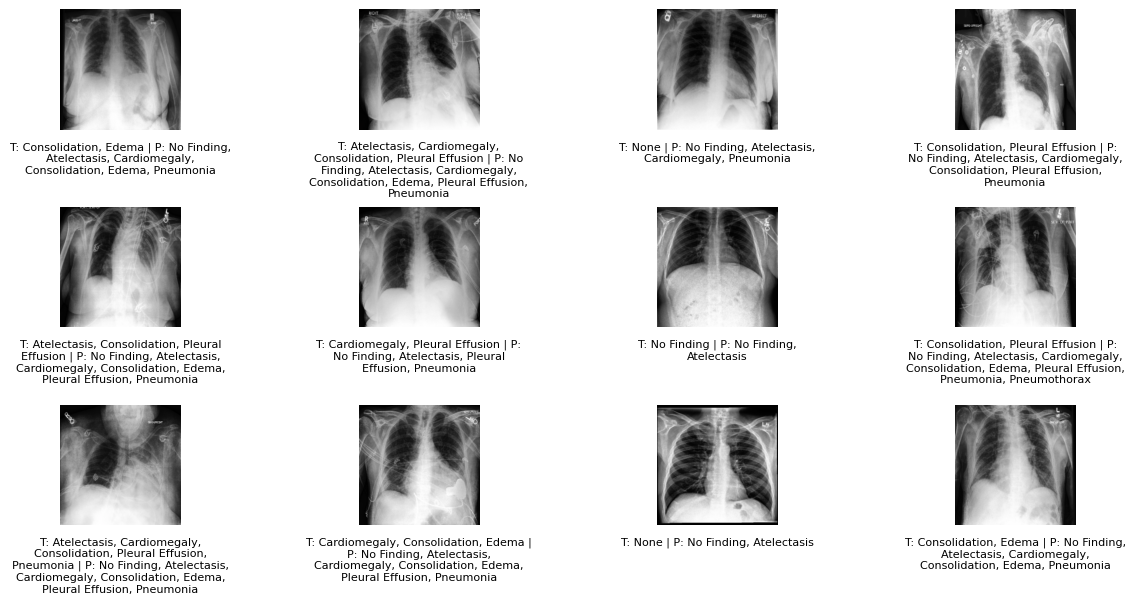

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=12)

---

In [ ]:
t2, ckpt_model = test_acc_ckpt_densenet121(densenet121_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=9)
print(f"Test Label-wise Accuracy: {t2*100:.4f} %")

Loaded model from epoch 9
Test Label-wise Accuracy: 56.4356 %


In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.676 | AP: 0.237
Atelectasis          | AUC: 0.767 | AP: 0.600
Cardiomegaly         | AUC: 0.782 | AP: 0.594
Consolidation        | AUC: 0.862 | AP: 0.888
Edema                | AUC: 0.874 | AP: 0.683
Pleural Effusion     | AUC: 0.828 | AP: 0.643
Pneumonia            | AUC: 0.727 | AP: 0.075
Pneumothorax         | AUC: 0.788 | AP: 0.149

------ Summary ------ 
Mean AUC: 0.788
Mean AP:  0.484
Macro F1: 0.469
Micro F1: 0.517


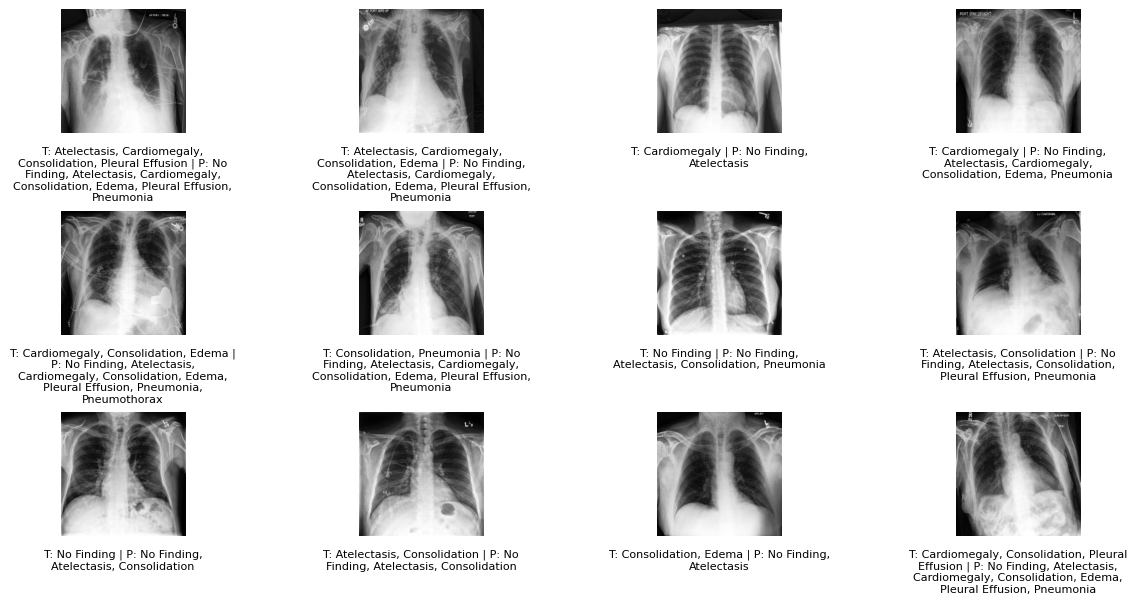

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

#### Vision Transformer(ViT_b_16)

In [ ]:
def test_acc_best_model_vit(CHECKPOINT_DIR, num_classes,test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model = build_vit_b_16(num_classes,False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()
  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")
  # Testing
  test_corrects,total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc, best_model

In [ ]:
def test_acc_ckpt_vit(CHECKPOINT_DIR,num_classes,test_loader,ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_vit_b_16(num_classes, False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects,total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels

  return test_acc, model

In [ ]:
vit_CHECKPOINT_DIR = os.path.join(EE782, f'vit_b_16_checkpoints_seed_{SEED}')
os.makedirs(vit_CHECKPOINT_DIR, exist_ok = True)
vit_CHECKPOINT_DIR

'/content/drive/MyDrive/EE782/vit_b_16_checkpoints_seed_42'

In [ ]:
vit_b_16_model    = build_vit_b_16(num_classes)
vit_b_16_model    = vit_b_16_model.to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:06<00:00, 54.5MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(vit_b_16_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train(vit_CHECKPOINT_DIR, vit_b_16_model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 507/507 [09:49<00:00,  1.16s/it]


Train Loss: 0.4115 | Train Accuracy: 0.8191



Val Epoch 1: 100%|██████████| 91/91 [00:35<00:00,  2.55it/s]


Validation Loss: 0.3446 | Validation Accuracy: 0.8488

New best model saved at epoch 1 with val accuracy = 0.8488

----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 507/507 [09:47<00:00,  1.16s/it]


Train Loss: 0.3461 | Train Accuracy: 0.8473



Val Epoch 2: 100%|██████████| 91/91 [00:34<00:00,  2.62it/s]


Validation Loss: 0.3525 | Validation Accuracy: 0.8491

New best model saved at epoch 2 with val accuracy = 0.8491

----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 507/507 [09:47<00:00,  1.16s/it]


Train Loss: 0.3290 | Train Accuracy: 0.8561



Val Epoch 3: 100%|██████████| 91/91 [00:34<00:00,  2.63it/s]


Validation Loss: 0.3307 | Validation Accuracy: 0.8535

New best model saved at epoch 3 with val accuracy = 0.8535

----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 507/507 [09:47<00:00,  1.16s/it]


Train Loss: 0.3113 | Train Accuracy: 0.8634



Val Epoch 4: 100%|██████████| 91/91 [00:34<00:00,  2.61it/s]


Validation Loss: 0.3468 | Validation Accuracy: 0.8532

----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 507/507 [09:46<00:00,  1.16s/it]


Train Loss: 0.2941 | Train Accuracy: 0.8739



Val Epoch 5: 100%|██████████| 91/91 [00:34<00:00,  2.63it/s]


Validation Loss: 0.3242 | Validation Accuracy: 0.8598

New best model saved at epoch 5 with val accuracy = 0.8598

----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 507/507 [09:47<00:00,  1.16s/it]


Train Loss: 0.2718 | Train Accuracy: 0.8849



Val Epoch 6: 100%|██████████| 91/91 [00:34<00:00,  2.62it/s]


Validation Loss: 0.3296 | Validation Accuracy: 0.8623

New best model saved at epoch 6 with val accuracy = 0.8623

----------------- Epoch 7 -----------------


Train Epoch 7: 100%|██████████| 507/507 [09:47<00:00,  1.16s/it]


Train Loss: 0.2480 | Train Accuracy: 0.8950



Val Epoch 7: 100%|██████████| 91/91 [00:34<00:00,  2.62it/s]


Validation Loss: 0.3799 | Validation Accuracy: 0.8324

----------------- Epoch 8 -----------------


Train Epoch 8: 100%|██████████| 507/507 [09:47<00:00,  1.16s/it]


Train Loss: 0.2167 | Train Accuracy: 0.9109



Val Epoch 8: 100%|██████████| 91/91 [00:34<00:00,  2.61it/s]


Validation Loss: 0.3594 | Validation Accuracy: 0.8554

----------------- Epoch 9 -----------------


Train Epoch 9: 100%|██████████| 507/507 [09:46<00:00,  1.16s/it]


Train Loss: 0.1770 | Train Accuracy: 0.9287



Val Epoch 9: 100%|██████████| 91/91 [00:34<00:00,  2.62it/s]


Validation Loss: 0.3810 | Validation Accuracy: 0.8532

----------------- Epoch 10 -----------------


Train Epoch 10: 100%|██████████| 507/507 [09:48<00:00,  1.16s/it]


Train Loss: 0.1349 | Train Accuracy: 0.9472



Val Epoch 10: 100%|██████████| 91/91 [00:39<00:00,  2.31it/s]


Validation Loss: 0.4361 | Validation Accuracy: 0.8506

----------------- Epoch 11 -----------------


Train Epoch 11: 100%|██████████| 507/507 [09:47<00:00,  1.16s/it]


Train Loss: 0.0901 | Train Accuracy: 0.9666



Val Epoch 11: 100%|██████████| 91/91 [00:35<00:00,  2.60it/s]


Validation Loss: 0.4751 | Validation Accuracy: 0.8413


Early stopping. No improvement in 5 epochs

Training complete. Best validation accuracy: 0.8623 at epoch 6


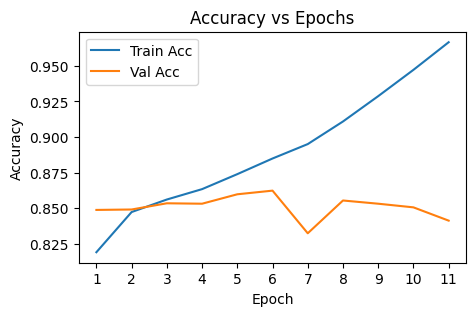

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_vit(vit_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 6 with val acc = 0.8623
Test Label-wise Accuracy: 54.8886 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.601 | AP: 0.150
Atelectasis          | AUC: 0.783 | AP: 0.592
Cardiomegaly         | AUC: 0.783 | AP: 0.612
Consolidation        | AUC: 0.859 | AP: 0.877
Edema                | AUC: 0.815 | AP: 0.612
Pleural Effusion     | AUC: 0.840 | AP: 0.729
Pneumonia            | AUC: 0.871 | AP: 0.279
Pneumothorax         | AUC: 0.784 | AP: 0.163

------ Summary ------ 
Mean AUC: 0.792
Mean AP:  0.502
Macro F1: 0.447
Micro F1: 0.504


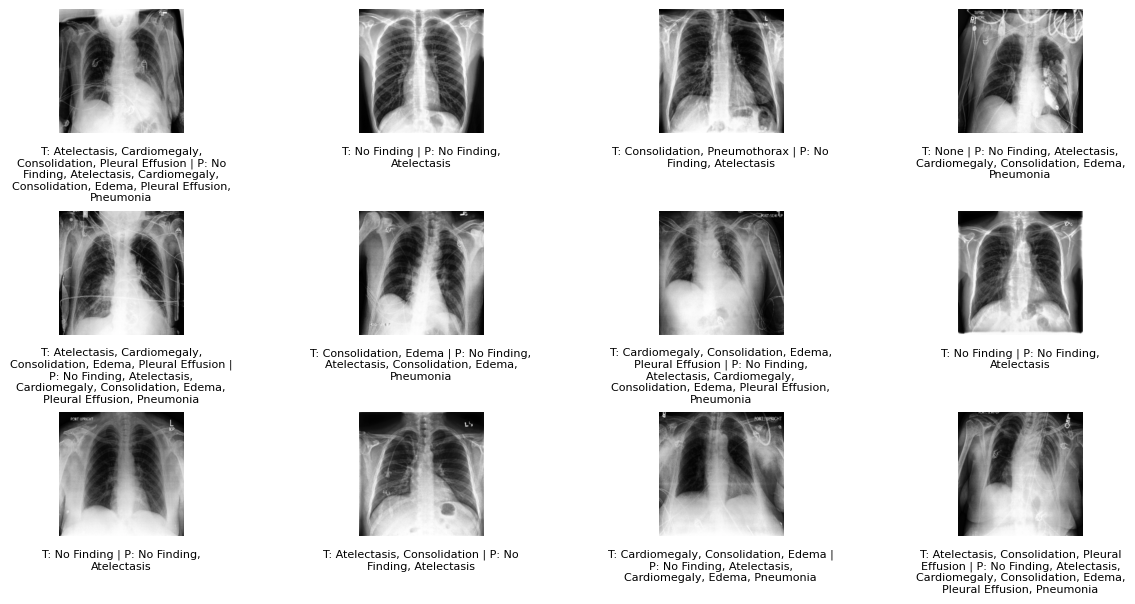

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=12)

---

In [ ]:
t2, ckpt_model= test_acc_ckpt_vit(vit_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=11)
print(f"Test Label-wise Accuracy: {t2*100:.4f} %")

Loaded model from epoch 11
Test Label-wise Accuracy: 56.8069 %


In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.603 | AP: 0.165
Atelectasis          | AUC: 0.734 | AP: 0.546
Cardiomegaly         | AUC: 0.776 | AP: 0.640
Consolidation        | AUC: 0.817 | AP: 0.822
Edema                | AUC: 0.816 | AP: 0.545
Pleural Effusion     | AUC: 0.838 | AP: 0.716
Pneumonia            | AUC: 0.782 | AP: 0.218
Pneumothorax         | AUC: 0.695 | AP: 0.119

------ Summary ------ 
Mean AUC: 0.758
Mean AP:  0.471
Macro F1: 0.449
Micro F1: 0.509


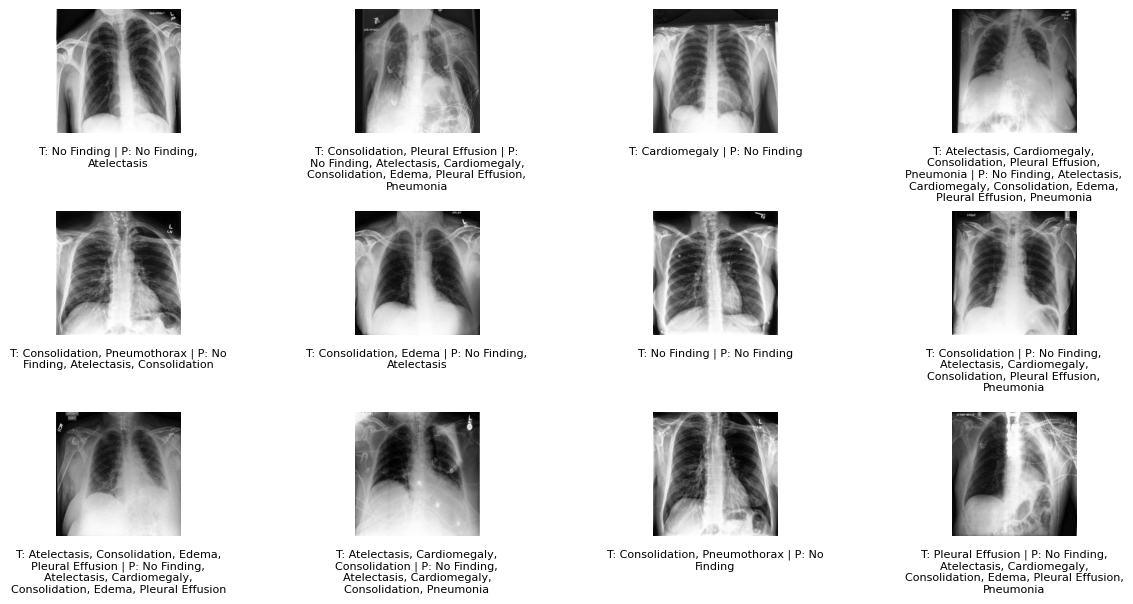

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

#### ConvNeXt-Tiny

In [ ]:
def test_acc_best_model_convnext(CHECKPOINT_DIR ,num_classes, test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model = build_convnext(num_classes, False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()

  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")
  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc, best_model

In [ ]:
def test_acc_ckpt_convnext(CHECKPOINT_DIR, num_classes, test_loader, ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_convnext(num_classes, False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc, model

In [ ]:
convnext_CHECKPOINT_DIR = os.path.join(EE782, f"convnext_checkpoints_seed_{SEED}")
os.makedirs(convnext_CHECKPOINT_DIR, exist_ok = True)
convnext_CHECKPOINT_DIR

'/content/drive/MyDrive/EE782/convnext_checkpoints_seed_42'

In [ ]:
convnext_model    = build_convnext(num_classes)
convnext_model    = convnext_model.to(device)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 119MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(convnext_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train(convnext_CHECKPOINT_DIR, convnext_model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 507/507 [06:47<00:00,  1.25it/s]


Train Loss: 0.3450 | Train Accuracy: 0.8492



Val Epoch 1: 100%|██████████| 91/91 [00:18<00:00,  5.01it/s]


Validation Loss: 0.3118 | Validation Accuracy: 0.8626

New best model saved at epoch 1 with val accuracy = 0.8626

----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 507/507 [06:39<00:00,  1.27it/s]


Train Loss: 0.2937 | Train Accuracy: 0.8733



Val Epoch 2: 100%|██████████| 91/91 [00:16<00:00,  5.39it/s]


Validation Loss: 0.3099 | Validation Accuracy: 0.8676

New best model saved at epoch 2 with val accuracy = 0.8676

----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 507/507 [06:40<00:00,  1.27it/s]


Train Loss: 0.2636 | Train Accuracy: 0.8900



Val Epoch 3: 100%|██████████| 91/91 [00:15<00:00,  5.71it/s]


Validation Loss: 0.2939 | Validation Accuracy: 0.8804

New best model saved at epoch 3 with val accuracy = 0.8804

----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 507/507 [06:40<00:00,  1.26it/s]


Train Loss: 0.2239 | Train Accuracy: 0.9094



Val Epoch 4: 100%|██████████| 91/91 [00:16<00:00,  5.41it/s]


Validation Loss: 0.3066 | Validation Accuracy: 0.8796

----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 507/507 [06:40<00:00,  1.27it/s]


Train Loss: 0.1695 | Train Accuracy: 0.9348



Val Epoch 5: 100%|██████████| 91/91 [00:17<00:00,  5.28it/s]


Validation Loss: 0.3224 | Validation Accuracy: 0.8786

----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 507/507 [06:38<00:00,  1.27it/s]


Train Loss: 0.1127 | Train Accuracy: 0.9592



Val Epoch 6: 100%|██████████| 91/91 [00:16<00:00,  5.60it/s]


Validation Loss: 0.3495 | Validation Accuracy: 0.8769

----------------- Epoch 7 -----------------


Train Epoch 7: 100%|██████████| 507/507 [06:40<00:00,  1.27it/s]


Train Loss: 0.0727 | Train Accuracy: 0.9748



Val Epoch 7: 100%|██████████| 91/91 [00:18<00:00,  5.03it/s]


Validation Loss: 0.4153 | Validation Accuracy: 0.8729

----------------- Epoch 8 -----------------


Train Epoch 8: 100%|██████████| 507/507 [06:38<00:00,  1.27it/s]


Train Loss: 0.0483 | Train Accuracy: 0.9846



Val Epoch 8: 100%|██████████| 91/91 [00:16<00:00,  5.55it/s]


Validation Loss: 0.4532 | Validation Accuracy: 0.8730


Early stopping. No improvement in 5 epochs

Training complete. Best validation accuracy: 0.8804 at epoch 3


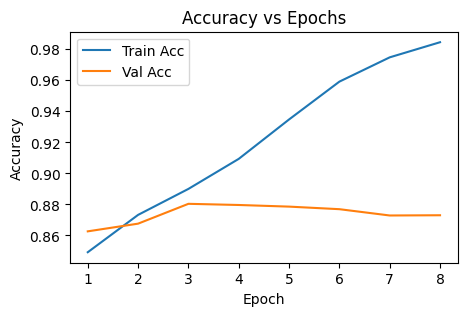

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_convnext(convnext_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 3 with val acc = 0.8804
Test Label-wise Accuracy: 53.4653 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.702 | AP: 0.203
Atelectasis          | AUC: 0.803 | AP: 0.637
Cardiomegaly         | AUC: 0.836 | AP: 0.730
Consolidation        | AUC: 0.893 | AP: 0.915
Edema                | AUC: 0.901 | AP: 0.753
Pleural Effusion     | AUC: 0.893 | AP: 0.794
Pneumonia            | AUC: 0.836 | AP: 0.148
Pneumothorax         | AUC: 0.722 | AP: 0.140

------ Summary ------ 
Mean AUC: 0.823
Mean AP:  0.540
Macro F1: 0.455
Micro F1: 0.508


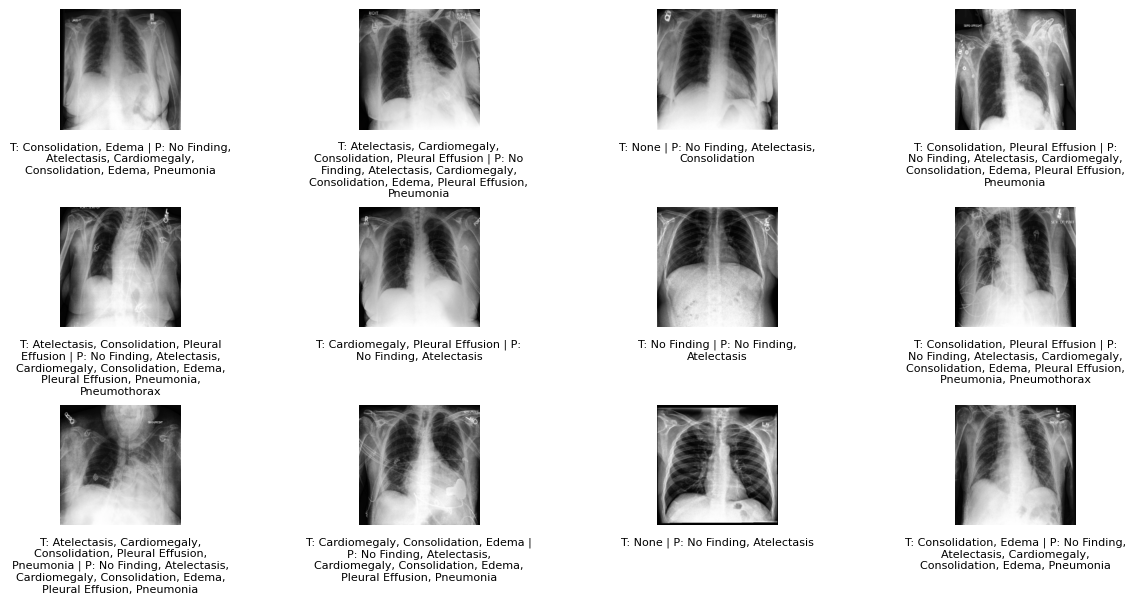

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=12)

---

In [ ]:
t2, ckpt_model= test_acc_ckpt_convnext(convnext_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=8)
print(f"Test Accuracy: {t2*100:.4f} %")

Loaded model from epoch 8
Test Accuracy: 52.3515 %


In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.805 | AP: 0.356
Atelectasis          | AUC: 0.732 | AP: 0.565
Cardiomegaly         | AUC: 0.825 | AP: 0.687
Consolidation        | AUC: 0.853 | AP: 0.837
Edema                | AUC: 0.870 | AP: 0.693
Pleural Effusion     | AUC: 0.874 | AP: 0.710
Pneumonia            | AUC: 0.778 | AP: 0.136
Pneumothorax         | AUC: 0.759 | AP: 0.092

------ Summary ------ 
Mean AUC: 0.812
Mean AP:  0.509
Macro F1: 0.449
Micro F1: 0.503


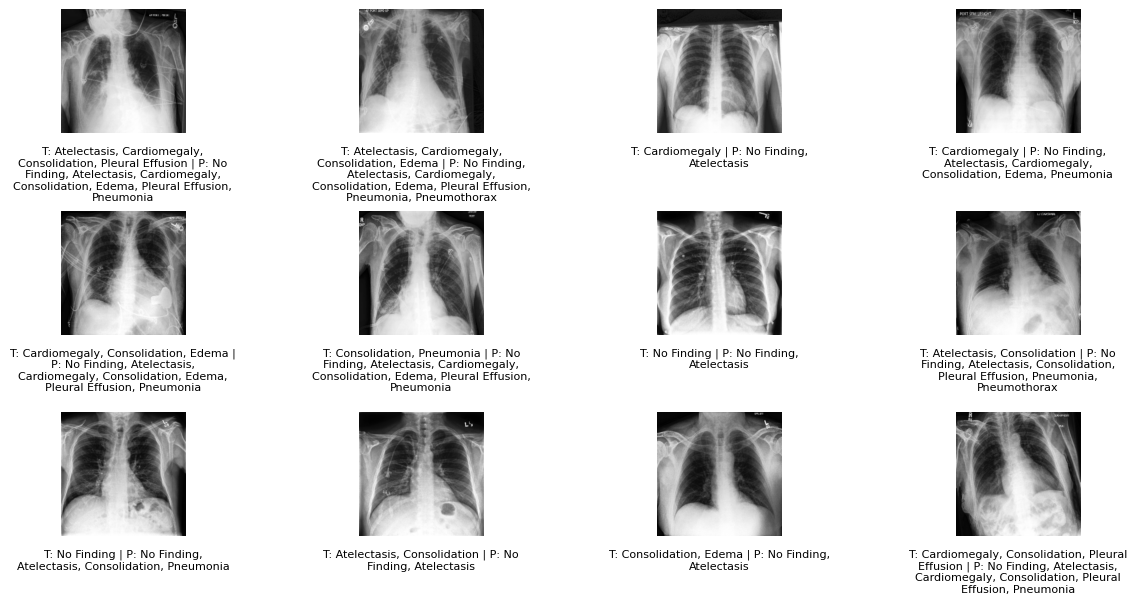

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

### Testing on other dataset(NIH ChestX-ray14)

#### NIH Chest X-Rays

##### Data

In [ ]:
NIH_DATA    = os.path.join(EE782, 'NIH_DATA')
NIH_CSV     = os.path.join(EE782, 'NIH_DATA/Data_Entry_2017.csv')
NIH_IMG_DIR = os.path.join(EE782, 'NIH_DATA/images_001/images')

In [ ]:
files = os.listdir(NIH_IMG_DIR)
len(files)

4999

In [ ]:
nih_df = pd.read_csv(NIH_CSV)
nih_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [ ]:
len(nih_df)

112120

* Considering only the images in the "images_001" folder for testing

In [ ]:
img_dir_files   = set(os.listdir(NIH_IMG_DIR))

In [ ]:
filtered_nih_df = nih_df[nih_df["Image Index"].isin(img_dir_files)].copy()

In [ ]:
filtered_nih_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [ ]:
len(filtered_nih_df)

4999

In [ ]:
# updating the "Image Index" column with image path
PATH_COL = "Image Index"
filtered_nih_df[PATH_COL] = filtered_nih_df[PATH_COL].apply(lambda fn: os.path.join(NIH_IMG_DIR, fn))

In [ ]:
filtered_nih_df.head()

Image Index          Finding Labels  \
0  /content/drive/MyDrive/EE782/NIH_DATA/images_0...            Cardiomegaly   
1  /content/drive/MyDrive/EE782/NIH_DATA/images_0...  Cardiomegaly|Emphysema   
2  /content/drive/MyDrive/EE782/NIH_DATA/images_0...   Cardiomegaly|Effusion   
3  /content/drive/MyDrive/EE782/NIH_DATA/images_0...              No Finding   
4  /content/drive/MyDrive/EE782/NIH_DATA/images_0...                  Hernia   

   Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
0            0           1           58              M            PA   
1            1           1           58              M            PA   
2            2           1           58              M            PA   
3            0           2           81              M            PA   
4            0           3           81              F            PA   

   OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
0                 2682     2749                        0.143  0.143   
1                 2894     2729                        0.143  0.143   
2                 2500     2048                        0.168  0.168   
3                 2500     2048                        0.171  0.171   
4                 2582     2991                        0.143  0.143   

   Unnamed: 11  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [ ]:
# NIH stores labels in a single string column "Finding Labels" (common), expanding them:
if "Finding Labels" in filtered_nih_df.columns and not any(c in filtered_nih_df.columns for c in nih_to_canon.keys()):

    # create one-hot columns from "Finding Labels" (strings like "Cardiomegaly|Effusion")
    filtered_nih_df["Finding Labels"] = filtered_nih_df["Finding Labels"].fillna("")
    for src in nih_to_canon.keys():
        filtered_nih_df[src] = filtered_nih_df["Finding Labels"].apply(lambda s: 1.0 if src in s.split("|") else 0.0)

In [ ]:
filtered_nih_df.head()

Image Index          Finding Labels  \
0  /content/drive/MyDrive/EE782/NIH_DATA/images_0...            Cardiomegaly   
1  /content/drive/MyDrive/EE782/NIH_DATA/images_0...  Cardiomegaly|Emphysema   
2  /content/drive/MyDrive/EE782/NIH_DATA/images_0...   Cardiomegaly|Effusion   
3  /content/drive/MyDrive/EE782/NIH_DATA/images_0...              No Finding   
4  /content/drive/MyDrive/EE782/NIH_DATA/images_0...                  Hernia   

   Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
0            0           1           58              M            PA   
1            1           1           58              M            PA   
2            2           1           58              M            PA   
3            0           2           81              M            PA   
4            0           3           81              F            PA   

   OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
0                 2682     2749                        0.143  0.143   
1                 2894     2729                        0.143  0.143   
2                 2500     2048                        0.168  0.168   
3                 2500     2048                        0.171  0.171   
4                 2582     2991                        0.143  0.143   

   Unnamed: 11  No Finding  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0          NaN         0.0          0.0           1.0            0.0    0.0   
1          NaN         0.0          0.0           1.0            0.0    0.0   
2          NaN         0.0          0.0           1.0            0.0    0.0   
3          NaN         1.0          0.0           0.0            0.0    0.0   
4          NaN         0.0          0.0           0.0            0.0    0.0   

   Effusion  Pneumonia  Pneumothorax  
0       0.0        0.0           0.0  
1       0.0        0.0           0.0  
2       1.0        0.0           0.0  
3       0.0        0.0           0.0  
4       0.0        0.0           0.0

In [ ]:
# making NIH canonical dataframe
nih_canon_df = make_canonical_df(filtered_nih_df, nih_to_canon, canonical, path_col=PATH_COL)
nih_canon_df.head()

Path  No Finding  \
0  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   
1  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   
2  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   
3  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         1.0   
4  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 1           1.0   
1                1          0.0                 1           1.0   
2                1          0.0                 1           1.0   
3                1          0.0                 1           0.0   
4                1          0.0                 1           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  1            0.0                   1    0.0           1   
1                  1            0.0                   1    0.0           1   
2                  1            0.0                   1    0.0           1   
3                  1            0.0                   1    0.0           1   
4                  1            0.0                   1    0.0           1   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      1        0.0               1   
1               0.0                      1        0.0               1   
2               1.0                      1        0.0               1   
3               0.0                      1        0.0               1   
4               0.0                      1        0.0               1   

   Pneumothorax  Pneumothorax_mask  
0           0.0                  1  
1           0.0                  1  
2           0.0                  1  
3           0.0                  1  
4           0.0                  1

In [ ]:
nih_canon_df.to_excel(os.path.join(NIH_DATA,'nih_canon_df.xlsx'), index=False)
print("DataFrame saved as 'nih_canon_df.xlsx'")

DataFrame saved as 'nih_canon_df.xlsx'


In [ ]:
# label prevalence
for c in canonical:
    valid = nih_canon_df[c + "_mask"].sum()
    positives = nih_canon_df[c].sum()
    print(f"{c:20s} | labeled: {int(valid):6d} | positives: {int(positives):6d} | prevalence: {positives/valid if valid>0 else np.nan:.3f}")

No Finding           | labeled:   4999 | positives:   2754 | prevalence: 0.551
Atelectasis          | labeled:   4999 | positives:    460 | prevalence: 0.092
Cardiomegaly         | labeled:   4999 | positives:    196 | prevalence: 0.039
Consolidation        | labeled:   4999 | positives:    205 | prevalence: 0.041
Edema                | labeled:   4999 | positives:     90 | prevalence: 0.018
Pleural Effusion     | labeled:   4999 | positives:    487 | prevalence: 0.097
Pneumonia            | labeled:   4999 | positives:     65 | prevalence: 0.013
Pneumothorax         | labeled:   4999 | positives:    199 | prevalence: 0.040


##### Custom Dataset Class

In [ ]:
class NIH_Dataset(Dataset):
    def __init__(self, df, transform=None, target_cols=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.target_cols = target_cols
        self.mask_cols = [c + "_mask" for c in target_cols]
        self.classes = target_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["Path"]
        image = Image.open(img_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row[self.target_cols].to_numpy(dtype=np.float32))
        mask = torch.tensor(row[self.mask_cols].to_numpy(dtype=np.float32))
        return image, label, mask

##### DataLoader

In [ ]:
nih_canon_df_pth = os.path.join(NIH_DATA,'nih_canon_df.xlsx')
nih_canon_df = pd.read_excel(nih_canon_df_pth)

In [ ]:
len(nih_canon_df)

4999

In [ ]:
nih_data_small = nih_canon_df.sample(frac=0.1, random_state=SEED).reset_index(drop=True)

In [ ]:
len(nih_data_small)

500

In [ ]:
nih_dataset      = NIH_Dataset(nih_data_small, transform=val_transforms, target_cols=canonical)
nih_test_loader  = DataLoader(nih_dataset, batch_size=32, shuffle=False,num_workers=2, pin_memory=True)

In [ ]:
img, labels, mask = next(iter(nih_test_loader))
print(img.shape)
print(labels.shape)
print(mask.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 8])
torch.Size([32, 8])


#### Testing

In [ ]:
num_classes = len(canonical)
num_classes

8

In [ ]:
SEED=42

##### ResNet50

In [ ]:
resnet50_CHECKPOINT_DIR = os.path.join(EE782, f'resnet50_checkpoints_seed_{SEED}')

In [ ]:
t1, best_model = test_acc_best_model_resnet50(resnet50_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 2 with val acc = 0.8742
Test Label-wise Accuracy: 50.3500 %


In [ ]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.675 | AP: 0.730
Atelectasis          | AUC: 0.707 | AP: 0.175
Cardiomegaly         | AUC: 0.835 | AP: 0.171
Consolidation        | AUC: 0.802 | AP: 0.154
Edema                | AUC: 0.925 | AP: 0.094
Pleural Effusion     | AUC: 0.879 | AP: 0.444
Pneumonia            | AUC: 0.632 | AP: 0.133
Pneumothorax         | AUC: 0.786 | AP: 0.186

------ Summary ------ 
Mean AUC: 0.780
Mean AP:  0.261
Macro F1: 0.232
Micro F1: 0.298


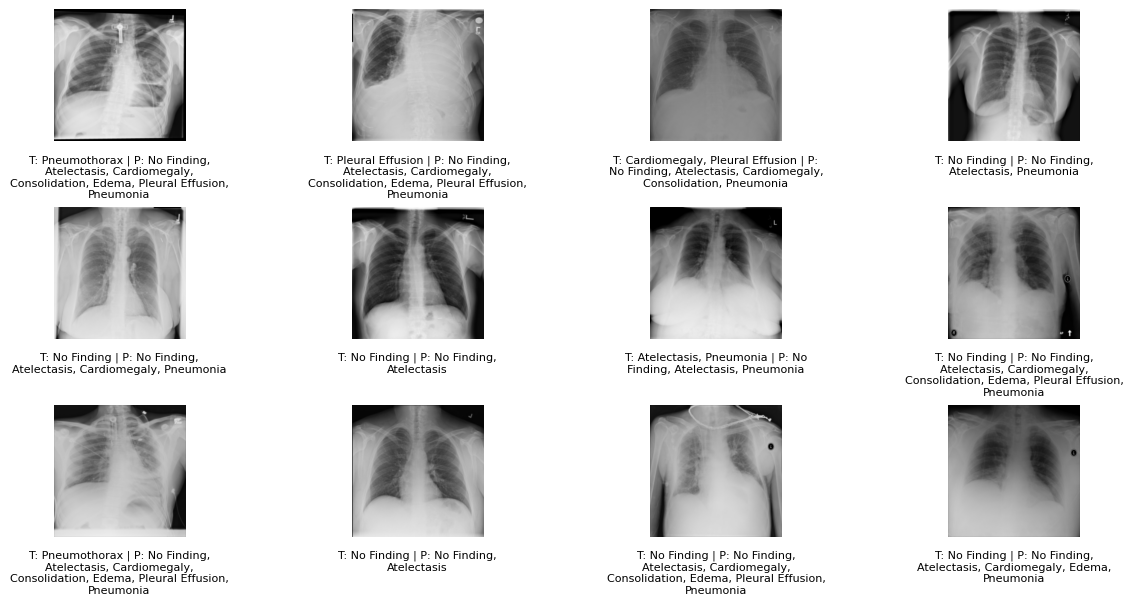

In [ ]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)

##### DenseNet121

In [ ]:
densenet121_CHECKPOINT_DIR = os.path.join(EE782, f'densenet121_checkpoints_seed_{SEED}')

In [ ]:
t1, best_model = test_acc_best_model_densenet121(densenet121_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 4 with val acc = 0.8763
Test Label-wise Accuracy: 58.1250 %


In [ ]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.604 | AP: 0.661
Atelectasis          | AUC: 0.718 | AP: 0.214
Cardiomegaly         | AUC: 0.868 | AP: 0.249
Consolidation        | AUC: 0.852 | AP: 0.136
Edema                | AUC: 0.933 | AP: 0.178
Pleural Effusion     | AUC: 0.873 | AP: 0.358
Pneumonia            | AUC: 0.598 | AP: 0.039
Pneumothorax         | AUC: 0.800 | AP: 0.261

------ Summary ------ 
Mean AUC: 0.781
Mean AP:  0.262
Macro F1: 0.243
Micro F1: 0.334


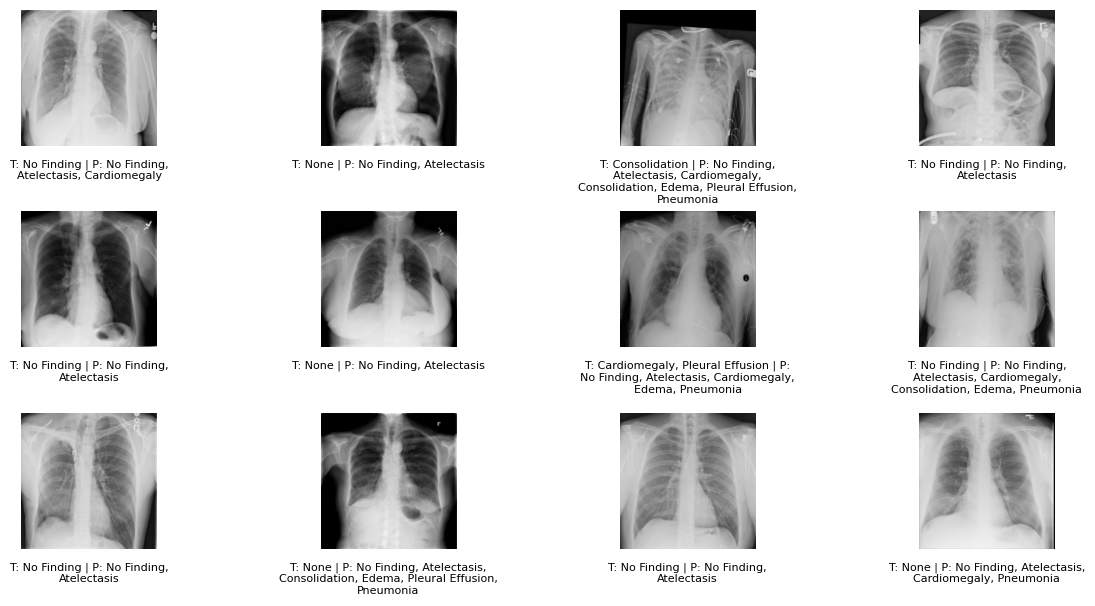

In [ ]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)

##### Vision Transformer(ViT_b_16)

In [ ]:
vit_CHECKPOINT_DIR = os.path.join(EE782, f'vit_b_16_checkpoints_seed_{SEED}')

In [ ]:
t1, best_model = test_acc_best_model_vit(vit_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 6 with val acc = 0.8623
Test Label-wise Accuracy: 58.2500 %


In [ ]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.583 | AP: 0.605
Atelectasis          | AUC: 0.706 | AP: 0.191
Cardiomegaly         | AUC: 0.888 | AP: 0.268
Consolidation        | AUC: 0.859 | AP: 0.166
Edema                | AUC: 0.957 | AP: 0.242
Pleural Effusion     | AUC: 0.827 | AP: 0.299
Pneumonia            | AUC: 0.634 | AP: 0.053
Pneumothorax         | AUC: 0.827 | AP: 0.276

------ Summary ------ 
Mean AUC: 0.785
Mean AP:  0.263
Macro F1: 0.237
Micro F1: 0.334


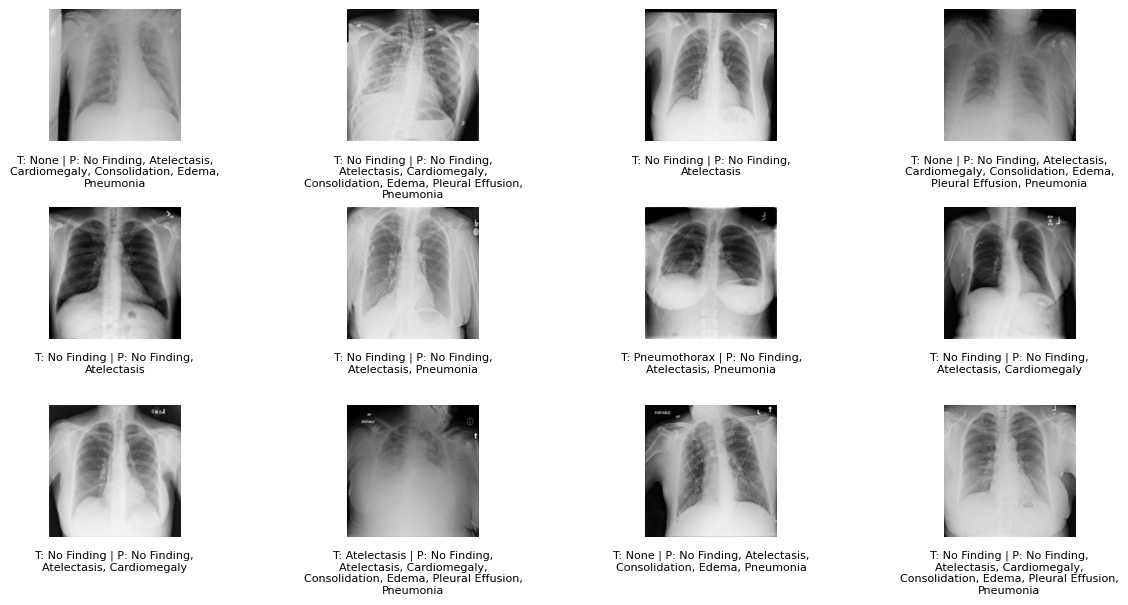

In [ ]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)

##### ConvNeXt-Tiny

In [ ]:
convnext_CHECKPOINT_DIR = os.path.join(EE782, f"convnext_checkpoints_seed_{SEED}")

In [ ]:
t1, best_model = test_acc_best_model_convnext(convnext_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 134MB/s]


Loaded best model from epoch 3 with val acc = 0.8804
Test Label-wise Accuracy: 57.1500 %


In [ ]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.690 | AP: 0.677
Atelectasis          | AUC: 0.695 | AP: 0.194
Cardiomegaly         | AUC: 0.846 | AP: 0.280
Consolidation        | AUC: 0.840 | AP: 0.126
Edema                | AUC: 0.953 | AP: 0.293
Pleural Effusion     | AUC: 0.898 | AP: 0.447
Pneumonia            | AUC: 0.612 | AP: 0.057
Pneumothorax         | AUC: 0.841 | AP: 0.187

------ Summary ------ 
Mean AUC: 0.797
Mean AP:  0.283
Macro F1: 0.239
Micro F1: 0.330


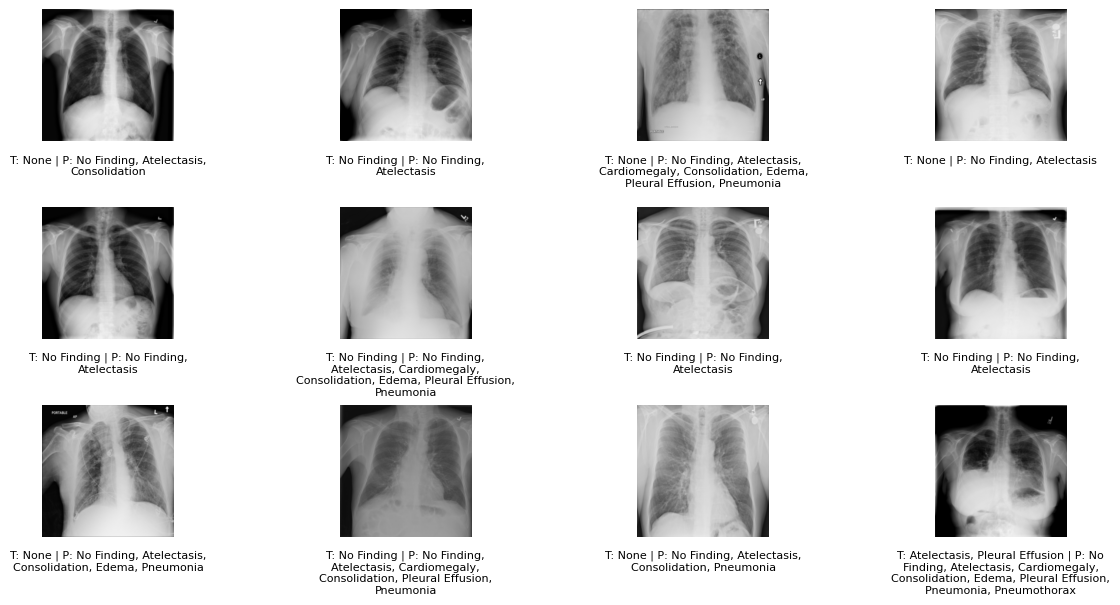

In [ ]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)